# Gemini 1.5 Pro Multiple Choice Shuffled

In [1]:
import sys
from pathlib import Path

BASEDIR = Path("/workspaces/HARP/") / "src"  # Replace with your own basedir path for the repo

sys.path.insert(0, str(BASEDIR))

In [2]:
from __future__ import annotations

import copy
import itertools
import json
import math
import os
import pickle
import pprint
import re
import textwrap
import time
import traceback
from collections import Counter, defaultdict
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tiktoken
from IPython.display import Markdown, clear_output, display
from tqdm.auto import tqdm

import vertexai
from vertexai.batch_prediction._batch_prediction import BatchPredictionJob

In [19]:
from eval.api import safe_unified_api_call
from eval.costs import count_tokens, get_pricing
from eval.eval import run_one, create_batch, make_answer_check_dict_from_jsonl
from eval.parsing_lib import *
from eval.latex_answer_check import *
from eval.prompt import create_prompt
from eval.prompts import *
from eval.utils import AMC_LETTER_CHOICES, read_jsonl, write_jsonl, get_uid, upload_blob, download_blob

# Data

In [27]:
# We don't use HARP_mcq.jsonl here because we used the original ordering of answer choices
dataset = [x for x in read_jsonl(BASEDIR / "data/processed/HARP_raw.jsonl") if x["choices"] is not None]# and x["subject"] != "calculus"]
dataset_map = {get_uid(p): p for p in dataset}
len(dataset)

4115

In [5]:
all([p["answer_choice"] is not None for p in dataset])

True

In [6]:
Counter([p["level"] for p in dataset])

Counter({2: 1612, 3: 1136, 1: 858, 4: 504})

In [7]:
Counter([p["answer_choice"] for p in dataset])

Counter({'D': 991, 'C': 934, 'B': 929, 'E': 641, 'A': 615})

In [8]:
{c: x / len(dataset) for c, x in Counter([p["answer_choice"] for p in dataset]).items()}

{'C': 0.2272506082725061,
 'D': 0.2411192214111922,
 'E': 0.1559610705596107,
 'A': 0.14963503649635038,
 'B': 0.22603406326034065}

In [9]:
sum((x / len(dataset))**2 for c, x in Counter([p["answer_choice"] for p in dataset]).items())

0.2075872153255072

# Run eval

In [10]:
vertexai.init(project=os.environ.get("VERTEXAI_PROJECT_ID"), location="us-central1")

In [11]:
BUCKET_NAME = os.environ.get("GCLOUD_BUCKET_NAME")  # Should have the form "cloud-ai-platform-<YOUR_BUCKET>"

## Shuffle choices

In [12]:
def get_derangement(length=5):
    letters = AMC_LETTER_CHOICES[:length]
    while True:
        shuffle = np.random.permutation(letters)
        is_derangement = True
        for l, x in zip(letters, shuffle):
            if l == x:
                is_derangement = False
        if is_derangement:
            return [str(x) for x in shuffle] + AMC_LETTER_CHOICES[length:]

def get_distinct_derangements(n, length=5):
    # Note that there's 44 unique derangements
    res = []
    for i in range(n):
        while True:
            d = get_derangement(length)
            if d not in res:
                res.append(d)
                break
    return res

In [13]:
def create_problem_with_shuffled_choices(prob, new_order):
    new_prob = prob.copy()
    
    new_choices = {}
    for letter, new_letter in zip(AMC_LETTER_CHOICES, new_order):
        new_choices[new_letter] = new_prob["choices"][letter]
    new_choices = {l: new_choices[l] for l in AMC_LETTER_CHOICES}
    new_prob["choices"] = new_choices
    new_prob["answer_choice"] = new_order[AMC_LETTER_CHOICES.index(new_prob["answer_choice"])]
    return new_prob

In [100]:
all_derangements = {}
for i, prob in enumerate(dataset):
    choices = prob["choices"]
    length = 5
    if "none of" in choices["E"].lower() or "all of" in choices["E"].lower():
        length = 4

    seen_ds = first_derangements[i].copy()
    for i in range(3):
        d = get_derangement(length)
        while d in seen_ds:
            d = get_derangement(length)
        seen_ds.append(d)
    all_derangements[get_uid(prob)] = seen_ds

with open(BASEDIR / "outputs/mcq/gemini-1.5-pro-002/mcq_derangements.pkl", "wb+") as f:
    pickle.dump(all_derangements, f)

In [33]:
with open(BASEDIR / "outputs/mcq/gemini-1.5-pro-002/mcq_derangements.pkl", "rb") as f:
    all_derangements = pickle.load(f)

In [34]:
TOTAL_RUNS = 5

datasets = [[] for _ in range(TOTAL_RUNS)]
for prob in dataset:
    derangements = all_derangements[get_uid(prob)]
    choices = prob["choices"]
    length = 5
    if "none of" in choices["E"].lower() or "all of" in choices["E"].lower():
        length = 4

    for t in range(TOTAL_RUNS):
        datasets[t].append(
            create_problem_with_shuffled_choices(prob, derangements[t])
        )

In [35]:
datasets_map = [{get_uid(p): p for p in datasets[t]} for t in range(TOTAL_RUNS)]

In [22]:
for t in range(TOTAL_RUNS):
    print(Counter(p["answer_choice"] for p in datasets[t]))

Counter({'E': 850, 'A': 848, 'D': 818, 'C': 798, 'B': 796})
Counter({'A': 932, 'E': 857, 'C': 777, 'B': 773, 'D': 771})
Counter({'E': 854, 'A': 853, 'B': 810, 'C': 798, 'D': 795})
Counter({'A': 888, 'E': 855, 'B': 794, 'C': 792, 'D': 781})
Counter({'A': 903, 'E': 871, 'C': 802, 'B': 798, 'D': 736})


## Create batch

In [ ]:
for t in range(TOTAL_RUNS):
    batch = create_batch(
        datasets[t],
        api="google",
        model="gemini-1.5-pro-002",
        fewshot_messages=[],
        system_prompt=gemini_multiple_choice_0shot_sysprompt,
        prompt_choices="newline_paren",
        max_tokens=2048,
        temperature=0,
        seed=0,
        stop_sequences=["I hope it is correct."],
        # just to remove irrelevant params
        logprobs=None,
        top_p=None,
    )
    write_jsonl(
        batch,
        BASEDIR / f"inputs/mcq/gemini-1.5-pro-002/batch_choices_newline-paren_shuffle{t+1}.jsonl",
    )

## Upload to cloud

In [ ]:
for t in range(TOTAL_RUNS):
    upload_blob(
        BUCKET_NAME,
        BASEDIR / f"inputs/mcq/gemini-1.5-pro-002/batch_choices_newline-paren_shuffle{t+1}.jsonl",
        f"prompt_data/mcq/gemini-1.5-pro-002/batch_choices_newline-paren_shuffle{t+1}.jsonl",
    )

## Run batch job

In [ ]:
for t in range(TOTAL_RUNS):
    BatchPredictionJob.submit(
        source_model="gemini-1.5-pro-002",
        input_dataset=f"gs://{BUCKET_NAME}/prompt_data/mcq/gemini-1.5-pro-002/batch_choices_newline-paren_shuffle{t+1}.jsonl",
        output_uri_prefix=f"gs://{BUCKET_NAME}/outputs/mcq/gemini-1.5-pro-002/batch_choices_newline-paren_shuffle{t+1}",
    )

In [ ]:
download_blob(
    BUCKET_NAME,
    "outputs/mcq/gemini-1.5-pro-002/batch_choices_newline-paren_shuffle1/prediction-model-<TIMESTAMP>/predictions.jsonl",
    BASEDIR / "outputs/mcq/gemini-1.5-pro-002/outputs_newline-paren_shuffle1.jsonl",
)
download_blob(
    BUCKET_NAME,
    "outputs/mcq/gemini-1.5-pro-002/batch_choices_newline-paren_shuffle2/prediction-model-<TIMESTAMP>/predictions.jsonl",
    BASEDIR / "outputs/mcq/gemini-1.5-pro-002/outputs_newline-paren_shuffle2.jsonl",
)
download_blob(
    BUCKET_NAME,
    "outputs/mcq/gemini-1.5-pro-002/batch_choices_newline-paren_shuffle3/prediction-model-<TIMESTAMP>/predictions.jsonl",
    BASEDIR / "outputs/mcq/gemini-1.5-pro-002/outputs_newline-paren_shuffle3.jsonl",
)
download_blob(
    BUCKET_NAME,
    "outputs/mcq/gemini-1.5-pro-002/batch_choices_newline-paren_shuffle4/prediction-model-<TIMESTAMP>/predictions.jsonl",
    BASEDIR / "outputs/mcq/gemini-1.5-pro-002/outputs_newline-paren_shuffle4.jsonl",
)
download_blob(
    BUCKET_NAME,
    "outputs/mcq/gemini-1.5-pro-002/batch_choices_newline-paren_shuffle5/prediction-model-<TIMESTAMP>/predictions.jsonl",
    BASEDIR / "outputs/mcq/gemini-1.5-pro-002/outputs_newline-paren_shuffle5.jsonl",
)

# Results

In [21]:
raw_responses = []
responses = []
raw_response_map = []
response_map = []
answer_check_results = []
results = []

for i in range(5):
    fname = BASEDIR / f"eval/outputs/albert/aops_choices/gemini-1.5-pro-002/hard_newline-paren_shuffle{i+1}.jsonl"

    raw_responses_shuffle_i = read_jsonl(fname)
    responses_shuffle_i = [
        {
            "uid": x["custom_id"],
            "system": x["request"]["system_instruction"],
            "prompt": x["request"]["contents"],
            "response": ModelResponse.from_response(x["response"], "google", used_batch_api=True)
        }
        for x in raw_responses_shuffle_i
        if x["status"] == ""
    ]
    raw_response_shuffle_i_map = {o["uid"]: raw for raw, o in zip(raw_responses_shuffle_i, responses_shuffle_i)}
    response_shuffle_i_map = {o["uid"]: o for o in responses_shuffle_i}

    answer_check_dicts_shuffle_i = make_answer_check_dict_from_jsonl(responses_shuffle_i, datasets_map[i])
    
    answer_check_results_shuffle_i = []
    for prob in tqdm(answer_check_dicts_shuffle_i):
        # If the generation didn't finish or otherwise failed, then we should mark as "incorrect"
        # Note that otherwise we might take a random value as the "answer" for a generation that hit max tokens
        model_ans = prob["generated_text"] if prob["finish_reason"] == "stop" else None
        gt = prob["answer_choice"]
        out = check_one_latex_answer(
            model_ans,
            gt,
            extract_policy="flex",
            eval_policy="aggressive",
        )
        
        model_ans_choice = extract_answer(model_ans, EXTRACT_RE_PATTERNS) if model_ans is not None else "F"
        model_ans_choice = remove_boxes_keep_content(clean_answer(model_ans_choice))
        gt_choice = remove_boxes_keep_content(clean_answer(gt))
        if out["is_correct"] != (model_ans_choice == gt_choice):
            print("DIDNT MATCH EXACT MATCH:", out)
        
        answer_check_results_shuffle_i.append({**prob, **out})
    results_shuffle_i_metadata = make_results_df(
        responses_shuffle_i, answer_check_results_shuffle_i, datasets_map[i], mode="mcq"
    )

    raw_responses.append(raw_responses_shuffle_i)
    responses.append(responses_shuffle_i)
    raw_response_map.append(raw_response_shuffle_i_map)
    response_map.append(response_shuffle_i_map)
    answer_check_results.append(answer_check_results_shuffle_i)
    results.append(results_shuffle_i_metadata)

100%|██████████████████████████████████████████████████████████████████████████████████████| 4115/4115 [00:05<00:00, 773.85it/s]


In [22]:
orig_results = [df.copy() for df in results]
results = [df.query("subject != 'calculus'") for df in results]

In [177]:
for i in range(5):
    RESULTS_FNAME = BASEDIR / f"eval/outputs/albert/results/gemini-1.5-pro-002_mcq_newlineparen_shuffle{i+1}.csv"
    orig_results[i].to_csv(RESULTS_FNAME)

In [23]:
for i in range(5):
    print(
        "Accuracy is {} / {} = {:.01f}%".format(
            results[i]["is_correct"].sum(),
            len(results[i]),
            results[i]["is_correct"].sum() / len(results[i]) * 100,
        )
    )

Accuracy is 3316 / 4110 = 80.7%
Accuracy is 3328 / 4110 = 81.0%
Accuracy is 3307 / 4110 = 80.5%
Accuracy is 3282 / 4110 = 79.9%
Accuracy is 3302 / 4110 = 80.3%


## Accuracy

In [24]:
def accuracy_by_split(df, col_name):
    counts = df.value_counts(col_name).sort_index().to_frame()
    acc = (
        100 * df.groupby(col_name)["is_correct"].sum()
        / df.groupby(col_name)["is_correct"].count()
    )
    return pd.concat([counts, acc], axis=1).rename(columns={"is_correct": "accuracy"})

In [184]:
for i in range(5):
    print(accuracy_by_split(results[i], "level"))

       count   accuracy
level                  
1        858  87.412587
2       1612  85.359801
3       1136  76.056338
4        504  64.682540
       count   accuracy
level                  
1        858  86.713287
2       1612  85.732010
3       1136  77.816901
4        504  63.095238
       count   accuracy
level                  
1        858  87.179487
2       1612  85.359801
3       1136  76.232394
4        504  62.896825
       count   accuracy
level                  
1        858  86.130536
2       1612  84.739454
3       1136  77.200704
4        504  59.523810
       count   accuracy
level                  
1        858  87.062937
2       1612  84.615385
3       1136  76.584507
4        504  63.690476


In [185]:
for i in range(5):
    print(accuracy_by_split(results[i], "subject"))

                          count   accuracy
subject                                   
algebra                     872  86.353211
counting_and_probability    600  71.333333
geometry                   1071  72.362278
number_theory               473  78.858351
prealgebra                  957  92.685475
precalculus                 137  72.992701
                          count   accuracy
subject                                   
algebra                     872  87.041284
counting_and_probability    600  72.500000
geometry                   1071  73.482726
number_theory               473  80.126850
prealgebra                  957  91.222571
precalculus                 137  69.343066
                          count   accuracy
subject                                   
algebra                     872  85.206422
counting_and_probability    600  72.166667
geometry                   1071  73.295985
number_theory               473  78.858351
prealgebra                  957  91.431557
precalculus

In [188]:
for i in range(5):
    print(results[i][~results[i]["mcq_only"]]["is_correct"].mean() * 100)

80.27909426013692
80.54239073196419
80.0684570826751
79.25223802001054
79.96313849394419


In [187]:
for i in range(5):
    print(accuracy_by_split(results[i][~results[i]["mcq_only"]], "level"))

       count   accuracy
level                  
1        799  86.983730
2       1505  84.983389
3       1036  75.482625
4        458  63.973799
       count   accuracy
level                  
1        799  86.232791
2       1505  85.249169
3       1036  77.509653
4        458  62.008734
       count   accuracy
level                  
1        799  86.608260
2       1505  84.983389
3       1036  75.675676
4        458  62.445415
       count   accuracy
level                  
1        799  85.607009
2       1505  84.119601
3       1036  76.640927
4        458  58.078603
       count   accuracy
level                  
1        799  86.608260
2       1505  84.252492
3       1036  76.158301
4        458  62.882096


## Compare with no-shuffle

In [25]:
fname_newlineparen = BASEDIR / "eval/outputs/albert/aops_choices/gemini-1.5-pro-002/hard_newline-paren.jsonl"

raw_responses_newlineparen = read_jsonl(fname_newlineparen)
responses_newlineparen = [
    {
        "uid": x["custom_id"],
        "system": x["request"]["system_instruction"],
        "prompt": x["request"]["contents"],
        "response": ModelResponse.from_response(x["response"], "google", used_batch_api=True)
    }
    for x in raw_responses_newlineparen
    if x["status"] == ""
]
raw_response_newlineparen_map = {o["uid"]: raw for raw, o in zip(raw_responses_newlineparen, responses_newlineparen)}
response_newlineparen_map = {o["uid"]: o for o in responses_newlineparen}

answer_check_dicts_newlineparen = make_answer_check_dict_from_jsonl(responses_newlineparen, dataset_map)

answer_check_results_newlineparen = []
for prob in tqdm(answer_check_dicts_newlineparen):
    # If the generation didn't finish or otherwise failed, then we should mark as "incorrect"
    # Note that otherwise we might take a random value as the "answer" for a generation that hit max tokens
    model_ans = prob["generated_text"] if prob["finish_reason"] == "stop" else None
    gt = prob["answer_choice"]
    out = check_one_latex_answer(
        model_ans,
        gt,
        extract_policy="flex",
        eval_policy="aggressive",
    )
    
    model_ans_choice = extract_answer(model_ans, EXTRACT_RE_PATTERNS) if model_ans is not None else "F"
    model_ans_choice = remove_boxes_keep_content(clean_answer(model_ans_choice))
    gt_choice = remove_boxes_keep_content(clean_answer(gt))
    if out["is_correct"] != (model_ans_choice == gt_choice):
        print("DIDNT MATCH EXACT MATCH:", out)
    
    answer_check_results_newlineparen.append({**prob, **out})

results_newlineparen_metadata = make_results_df(
    responses_newlineparen, answer_check_results_newlineparen, dataset_map, mode="mcq"
)

100%|██████████████████████████████████████████████████████████████████████████████████████| 4115/4115 [00:05<00:00, 745.13it/s]


In [28]:
ACCURACY_COLUMNS = [
    "is_correct_original",
    *[f"is_correct_shuffle_{i+1}" for i in range(5)],
]

In [26]:
df = pd.concat([
    (
        results_newlineparen_metadata
        .set_index(["level", "subject", "has_asy_problem", "has_asy_solution", "mcq_only"], append=True)
        .assign(mode="original")
    ),
    *[
        (
            results[i]
            .set_index(["level", "subject", "has_asy_problem", "has_asy_solution", "mcq_only"], append=True)
            .assign(mode=f"shuffle_{i+1}")
        )
        for i in range(5)
    ]
]).set_index("mode", append=True)

In [27]:
df = df.unstack("mode")
df.columns = df.columns.map("_".join)
df = df.reset_index().set_index("uid")
df["num_correct"] = df[ACCURACY_COLUMNS].sum(axis=1)
df.head()

,level,subject,has_asy_problem,has_asy_solution,mcq_only,reason_original,reason_shuffle_1,reason_shuffle_2,reason_shuffle_3,reason_shuffle_4,...,output_tokens_shuffle_2,output_tokens_shuffle_3,output_tokens_shuffle_4,output_tokens_shuffle_5,reasoning_tokens_original,reasoning_tokens_shuffle_1,reasoning_tokens_shuffle_2,reasoning_tokens_shuffle_3,reasoning_tokens_shuffle_4,reasoning_tokens_shuffle_5
uid,,,,,,,,,,,,,,,,,,,,,
1950/AHSME/1,2,prealgebra,False,False,False,stop,stop,stop,stop,stop,...,148.0,148.0,148.0,143.0,0.0,0.0,0.0,0.0,0.0,0.0
1950/AHSME/10,2,prealgebra,False,False,False,stop,stop,stop,stop,stop,...,329.0,240.0,257.0,317.0,0.0,0.0,0.0,0.0,0.0,0.0
1950/AHSME/11,2,prealgebra,False,False,True,stop,stop,stop,stop,stop,...,198.0,228.0,206.0,215.0,0.0,0.0,0.0,0.0,0.0,0.0
1950/AHSME/12,2,geometry,False,False,True,stop,stop,stop,stop,stop,...,139.0,176.0,175.0,185.0,0.0,0.0,0.0,0.0,0.0,0.0
1950/AHSME/13,2,algebra,False,False,False,stop,stop,stop,stop,stop,...,208.0,226.0,208.0,223.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
def plot_intersect_accuracy(
    df,
    title="Common accuracy of multiple shuffled MCQ runs on Gemini 1.5 Pro v2",
):
    print(df[ACCURACY_COLUMNS].mean())
    print("Average 1 model perf:", df[ACCURACY_COLUMNS].mean().mean())
    
    single_bootstrap_res = stats.bootstrap((df[ACCURACY_COLUMNS].mean().to_numpy(),), np.mean, confidence_level=0.95)
    print("Single accuracy: {:.02f} +/- {:.02f}".format(
        100 * df[ACCURACY_COLUMNS].mean().mean(),
        100 * (single_bootstrap_res.confidence_interval.high - single_bootstrap_res.confidence_interval.low) / 2
    ))
    
    all_pair_acc = []
    for i, col1 in enumerate(ACCURACY_COLUMNS):
        for col2 in ACCURACY_COLUMNS[i+1:]:
            pair_acc = df[[col1, col2]].prod(axis=1).mean()
            all_pair_acc.append(pair_acc)
            # print(f"{col1} & {col2}: {pair_acc}")
    
    pair_bootstrap_res = stats.bootstrap((all_pair_acc,), np.mean, confidence_level=0.95)
    print("2-intersect accuracy: {:.02f} +/- {:.02f}".format(
        100 * sum(all_pair_acc) / len(all_pair_acc),
        100 * (pair_bootstrap_res.confidence_interval.high - pair_bootstrap_res.confidence_interval.low) / 2
    ))
    
    all_trio_acc = []
    for i, col1 in enumerate(ACCURACY_COLUMNS):
        for j, col2 in enumerate(ACCURACY_COLUMNS[i+1:]):
            for k, col3 in enumerate(ACCURACY_COLUMNS[j+1:]):
                acc = df[[col1, col2, col3]].prod(axis=1).mean()
                all_trio_acc.append(acc)
                # print(f"{col1.split('is_correct_')[1]} & {col2.split('is_correct_')[1]} & {col3.split('is_correct_')[1]}: {acc}")
    
    trio_bootstrap_res = stats.bootstrap((all_trio_acc,), np.mean, confidence_level=0.95)
    print("3-intersect accuracy: {:.02f} +/- {:.02f}".format(
        100 * sum(all_trio_acc) / len(all_trio_acc),
        100 * (trio_bootstrap_res.confidence_interval.high - trio_bootstrap_res.confidence_interval.low) / 2
    ))
    
    all_quad_acc = []
    for i, col1 in enumerate(ACCURACY_COLUMNS):
        for j, col2 in enumerate(ACCURACY_COLUMNS[i+1:]):
            for k, col3 in enumerate(ACCURACY_COLUMNS[j+1:]):
                for l, col4 in enumerate(ACCURACY_COLUMNS[k+1:]):
                    acc = df[[col1, col2, col3, col4]].prod(axis=1).mean()
                    all_quad_acc.append(acc)
    
    quad_bootstrap_res = stats.bootstrap((all_quad_acc,), np.mean, confidence_level=0.95)
    print("4-intersect accuracy: {:.02f} +/- {:.02f}".format(
        100 * sum(all_quad_acc) / len(all_quad_acc),
        100 * (quad_bootstrap_res.confidence_interval.high - quad_bootstrap_res.confidence_interval.low) / 2
    ))
    
    all_quin_acc = []
    for i, col1 in enumerate(ACCURACY_COLUMNS):
        acc = df[[col for col in ACCURACY_COLUMNS if col != col1]].prod(axis=1).mean()
        all_quin_acc.append(acc)
    
    quin_bootstrap_res = stats.bootstrap((all_quin_acc,), np.mean, confidence_level=0.95)
    print("5-intersect accuracy: {:.02f} +/- {:.02f}".format(
        100 * sum(all_quin_acc) / len(all_quin_acc),
        100 * (quin_bootstrap_res.confidence_interval.high - quin_bootstrap_res.confidence_interval.low) / 2
    ))
    
    all6_accuracy = df["is_correct_original"].copy()
    for c in ACCURACY_COLUMNS[1:]:
        all6_accuracy *= df[c]
    print(f"All-6 accuracy: {all6_accuracy.mean()*100:.02f}")
    
    xs = list(range(1,6))
    accs = np.array([
        100 * df[ACCURACY_COLUMNS].mean().mean(),
        100 * sum(all_pair_acc) / len(all_pair_acc),
        100 * sum(all_trio_acc) / len(all_trio_acc),
        100 * sum(all_quad_acc) / len(all_quad_acc),
        100 * sum(all_quin_acc) / len(all_quin_acc),
    ])
    cis = np.array([
        100 * (single_bootstrap_res.confidence_interval.high - single_bootstrap_res.confidence_interval.low) / 2,
        100 * (pair_bootstrap_res.confidence_interval.high - pair_bootstrap_res.confidence_interval.low) / 2,
        100 * (trio_bootstrap_res.confidence_interval.high - trio_bootstrap_res.confidence_interval.low) / 2,
        100 * (quad_bootstrap_res.confidence_interval.high - quad_bootstrap_res.confidence_interval.low) / 2,
        100 * (quin_bootstrap_res.confidence_interval.high - quin_bootstrap_res.confidence_interval.low) / 2,
    ])
    
    fig, ax = plt.subplots()
    ax.plot(xs, accs)
    ax.fill_between(xs, (accs-cis), (accs+cis), color='b', alpha=.1)
    
    plt.xticks(np.arange(1, 6, 1.0))
    plt.xlabel("Number of runs to intersect")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.grid(True)
    plt.show()

is_correct_original     0.810936
is_correct_shuffle_1    0.806813
is_correct_shuffle_2    0.809732
is_correct_shuffle_3    0.804623
is_correct_shuffle_4     0.79854
is_correct_shuffle_5    0.803406
dtype: object
Average 1 model perf: 0.8056749927815373
Single accuracy: 80.57 +/- 0.33
2-intersect accuracy: 73.91 +/- 0.20
3-intersect accuracy: 71.58 +/- 0.49
4-intersect accuracy: 70.13 +/- 0.26
5-intersect accuracy: 66.01 +/- 0.18
All-6 accuracy: 64.57


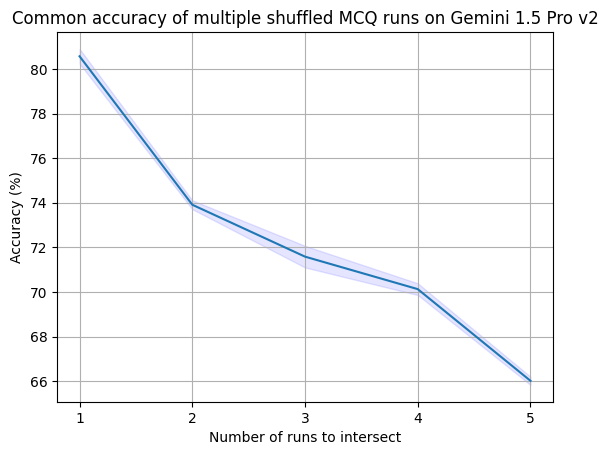

In [285]:
plot_intersect_accuracy(df)

is_correct_original     0.807257
is_correct_shuffle_1    0.802791
is_correct_shuffle_2    0.805424
is_correct_shuffle_3    0.800685
is_correct_shuffle_4    0.792522
is_correct_shuffle_5    0.799631
dtype: object
Average 1 model perf: 0.8013851023722253
Single accuracy: 80.14 +/- 0.39
2-intersect accuracy: 73.42 +/- 0.21
3-intersect accuracy: 71.07 +/- 0.48
4-intersect accuracy: 69.60 +/- 0.26
5-intersect accuracy: 65.51 +/- 0.19
All-6 accuracy: 64.06


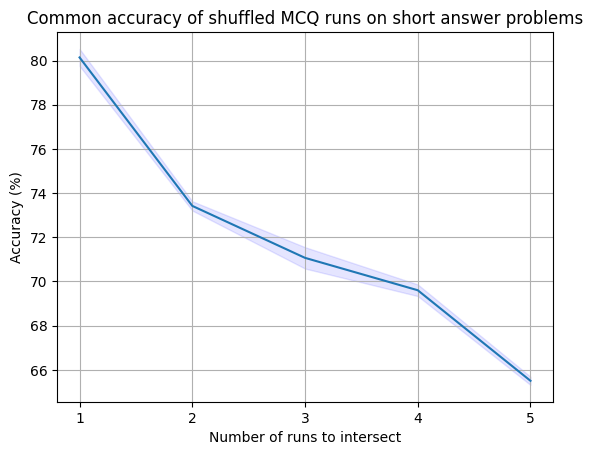

In [286]:
plot_intersect_accuracy(df[~df["mcq_only"]], title="Common accuracy of shuffled MCQ runs on short answer problems")

In [51]:
df[~df["mcq_only"]]["num_correct"].value_counts().sort_index()

num_correct
0     234
1     198
2     212
3     182
4     220
5     324
6    2433
Name: count, dtype: int64

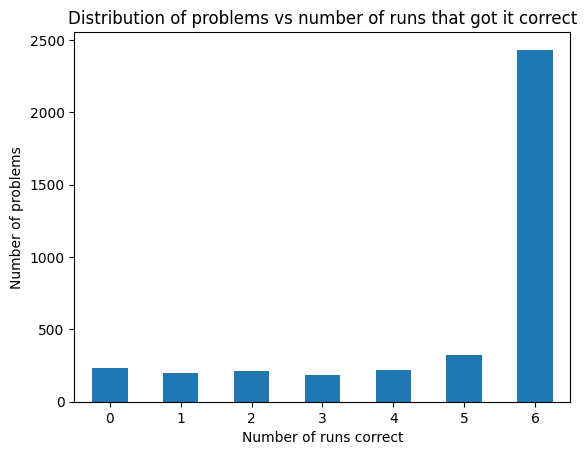

In [50]:
ax = df[~df["mcq_only"]]["num_correct"].value_counts().sort_index().plot(kind='bar')

plt.xlabel("Number of runs correct")
plt.xticks(rotation=0)
plt.ylabel("Number of problems")
plt.title("Distribution of problems vs number of runs that got it correct")
plt.show()

In [118]:
df.value_counts([
    "is_correct_original",
    "is_correct_shuffle_1",
    "is_correct_shuffle_2",
]).sort_index()

is_correct_original  is_correct_shuffle_1  is_correct_shuffle_2
False                False                 False                    399
                                           True                     132
                     True                  False                    112
                                           True                     135
True                 False                 False                    118
                                           True                     146
                     True                  False                    154
                                           True                    2919
Name: count, dtype: int64

In [82]:
2919 / len(results_newlineparen_metadata) * 100

70.9356014580802

In [119]:
df.value_counts([
    "level",
    "is_correct_original",
    "is_correct_shuffle_1",
    "is_correct_shuffle_2",
]).sort_index()

level  is_correct_original  is_correct_shuffle_1  is_correct_shuffle_2
1      False                False                 False                     56
                                                  True                      16
                            True                  False                     17
                                                  True                      17
       True                 False                 False                     20
                                                  True                      16
                            True                  False                     21
                                                  True                     695
2      False                False                 False                    115
                                                  True                      38
                            True                  False                     28
                                                  True      

In [91]:
df[
    [not dataset_map[x]["multiple_choice_only"] for x in df.index.get_level_values("uid")]
].value_counts([
    "is_correct_original",
    "is_correct_shuffle_1",
    "is_correct_shuffle_2",
]).sort_index()

(is_correct, original)  (is_correct, shuffle_1)  (is_correct, shuffle_2)
False                   False                    False                       380
                                                 True                        122
                        True                     False                       105
                                                 True                        126
True                    False                    False                       111
                                                 True                        137
                        True                     False                       144
                                                 True                       2678
Name: count, dtype: int64

In [92]:
2678 / len(df[[not dataset_map[x]["multiple_choice_only"] for x in df.index.get_level_values("uid")]])

0.7041809098080463

In [90]:
df[
    [not dataset_map[x]["multiple_choice_only"] for x in df.index.get_level_values("uid")]
].value_counts([
    "level",
    "is_correct_original",
    "is_correct_shuffle_1",
    "is_correct_shuffle_2",
]).sort_index()

level  (is_correct, original)  (is_correct, shuffle_1)  (is_correct, shuffle_2)
1      False                   False                    False                        55
                                                        True                         15
                               True                     False                        16
                                                        True                         17
       True                    False                    False                        19
                                                        True                         15
                               True                     False                        20
                                                        True                        642
2      False                   False                    False                       110
                                                        True                         35
                               True     

## Compare with short answer

In [144]:
responses_shortans = [
    {
        "uid": x["custom_id"],
        "system": x["request"]["system_instruction"],
        "prompt": x["request"]["contents"],
        "response": ModelResponse.from_response(x["response"], "google", used_batch_api=True)
    }
    for x in read_jsonl(BASEDIR / "eval/outputs/albert/aops/gemini-1.5-pro-002/hard_zeroshot.jsonl")
]
response_shortans_map = {o["uid"]: o for o in responses_shortans}

In [30]:
shortans_res = pd.read_csv(BASEDIR / "eval/outputs/albert/results/gemini-1.5-pro-002.csv").set_index("uid")

In [31]:
shortans_res[["AIME" not in x for x in shortans_res.index]].query("subject != 'calculus'")["is_correct"].mean()

np.float64(0.6421800947867299)

In [113]:
shortans_res.head()

,level,subject,has_asy_problem,has_asy_solution,reason,is_correct,answer,predict,input_tokens,output_tokens,reasoning_tokens
uid,,,,,,,,,,,
1984/AIME/10,5,algebra,False,False,stop,False,$119$,85,202,948,0
2010/AMC_12B/20,3,precalculus,False,False,stop,False,$8$,4,118,894,0
1964/AHSME/7,2,algebra,False,False,stop,True,$2$,2,93,365,0
2018/AMC_10A/19,2,counting_and_probability,False,False,stop,True,$\frac{2}{5}$,\frac{2}{5},136,833,0
2002/AIME_I/11,5,geometry,False,False,stop,False,$230$,25,202,833,0


In [114]:
df.head()

reason  \
mode                                                            original   
uid           level subject    has_asy_problem has_asy_solution            
1950/AHSME/1  2     prealgebra False           False                stop   
1950/AHSME/10 2     prealgebra False           False                stop   
1950/AHSME/11 2     prealgebra False           False                stop   
1950/AHSME/12 2     geometry   False           False                stop   
1950/AHSME/13 2     algebra    False           False                stop   

                                                                           \
mode                                                            shuffle_1   
uid           level subject    has_asy_problem has_asy_solution             
1950/AHSME/1  2     prealgebra False           False                 stop   
1950/AHSME/10 2     prealgebra False           False                 stop   
1950/AHSME/11 2     prealgebra False           False                 stop   
1950/AHSME/12 2     geometry   False           False                 stop   
1950/AHSME/13 2     algebra    False           False                 stop   

                                                                           \
mode                                                            shuffle_2   
uid           level subject    has_asy_problem has_asy_solution             
1950/AHSME/1  2     prealgebra False           False                 stop   
1950/AHSME/10 2     prealgebra False           False                 stop   
1950/AHSME/11 2     prealgebra False           False                 stop   
1950/AHSME/12 2     geometry   False           False                 stop   
1950/AHSME/13 2     algebra    False           False                 stop   

                                                                is_correct  \
mode                                                              original   
uid           level subject    has_asy_problem has_asy_solution              
1950/AHSME/1  2     prealgebra False           False                  True   
1950/AHSME/10 2     prealgebra False           False                 False   
1950/AHSME/11 2     prealgebra False           False                  True   
1950/AHSME/12 2     geometry   False           False                  True   
1950/AHSME/13 2     algebra    False           False                  True   

                                                                           \
mode                                                            shuffle_1   
uid           level subject    has_asy_problem has_asy_solution             
1950/AHSME/1  2     prealgebra False           False                 True   
1950/AHSME/10 2     prealgebra False           False                False   
1950/AHSME/11 2     prealgebra False           False                 True   
1950/AHSME/12 2     geometry   False           False                 True   
1950/AHSME/13 2     algebra    False           False                 True   

                                                                           \
mode                                                            shuffle_2   
uid           level subject    has_asy_problem has_asy_solution             
1950/AHSME/1  2     prealgebra False           False                 True   
1950/AHSME/10 2     prealgebra False           False                 True   
1950/AHSME/11 2     prealgebra False           False                 True   
1950/AHSME/12 2     geometry   False           False                 True   
1950/AHSME/13 2     algebra    False           False                 True   

                                                                  answer  \
mode                                                            original   
uid           level subject    has_asy_problem has_asy_solution            
1950/AHSME/1  2     prealgebra False           False                   C   
1950/AHSME/10 2     prealgebra False           False        

In [126]:
df_all = pd.merge(
    shortans_res.set_index(["level", "subject", "has_asy_problem", "has_asy_solution"], append=True),
    df,
    left_index=True,
    right_index=True,
    how="inner"
).reset_index().set_index("uid")

In [127]:
len(df_all)

3803

In [135]:
df_all[["reason", "reason_original", "reason_shuffle_1", "reason_shuffle_2"]].value_counts()

reason     reason_original  reason_shuffle_1  reason_shuffle_2
stop       stop             stop              stop                3727
                            length            stop                  24
                            stop              length                24
           length           stop              stop                  12
           stop             length            length                 3
                            stop              copyright              3
length     stop             stop              stop                   3
stop       stop             copyright         stop                   2
           length           stop              length                 2
           copyright        copyright         copyright              1
copyright  stop             stop              stop                   1
length     stop             length            stop                   1
Name: count, dtype: int64

In [130]:
df_all[["is_correct", "is_correct_original", "is_correct_shuffle_1", "is_correct_shuffle_2"]].value_counts() / len(df_all)

is_correct  is_correct_original  is_correct_shuffle_1  is_correct_shuffle_2
True        True                 True                  True                    0.571391
False       True                 True                  True                    0.132790
            False                False                 False                   0.088614
                                                       True                    0.024980
            True                 True                  False                   0.024191
            False                True                  False                   0.022351
            True                 False                 True                    0.022088
            False                True                  True                    0.021299
            True                 False                 False                   0.021299
True        True                 False                 True                    0.013936
                                 True       

In [132]:
df_all.query("is_correct")[["is_correct_original", "is_correct_shuffle_1", "is_correct_shuffle_2"]].value_counts() / len(df_all.query("is_correct"))

is_correct_original  is_correct_shuffle_1  is_correct_shuffle_2
True                 True                  True                    0.889480
                     False                 True                    0.021695
                     True                  False                   0.021285
False                True                  True                    0.018420
                     False                 False                   0.017601
True                 False                 False                   0.012280
False                False                 True                    0.011052
                     True                  False                   0.008187
Name: count, dtype: float64

In [133]:
df_all.query("~is_correct")[["is_correct_original", "is_correct_shuffle_1", "is_correct_shuffle_2"]].value_counts() / len(df_all.query("~is_correct"))

is_correct_original  is_correct_shuffle_1  is_correct_shuffle_2
True                 True                  True                    0.371324
False                False                 False                   0.247794
                                           True                    0.069853
True                 True                  False                   0.067647
False                True                  False                   0.062500
True                 False                 True                    0.061765
False                True                  True                    0.059559
True                 False                 False                   0.059559
Name: count, dtype: float64

In [143]:
df_all.loc["2024/AMC_8/1"]

level                                  1
subject                    number_theory
has_asy_problem                    False
has_asy_solution                   False
reason                              stop
is_correct                          True
answer                               $2$
predict                                2
input_tokens                         100
output_tokens                        493
reasoning_tokens                       0
reason_original                     stop
reason_shuffle_1                    stop
reason_shuffle_2                    stop
is_correct_original                False
is_correct_shuffle_1               False
is_correct_shuffle_2                True
answer_original                        B
answer_shuffle_1                       A
answer_shuffle_2                       C
predict_original                       c
predict_shuffle_1                      c
predict_shuffle_2                      c
input_tokens_original                143
input_tokens_shu

In [154]:
rand_uid = np.random.choice(
    df_all
    .query("reason == 'stop' and reason_original == 'stop' and reason_shuffle_1 == 'stop' and reason_shuffle_2 == 'stop'")
    .query("is_correct and (not is_correct_original or not is_correct_shuffle_1 or not is_correct_shuffle_2)")
    .index
)

# had the right answer, but picked the wrong answer choice
# rand_uid = "1996/AHSME/15"

# rand_uid = "2012/AMC_10A/4"

print(rand_uid)
print(dataset_map[rand_uid]["subject"], dataset_map[rand_uid]["level"])
print(df_all[["is_correct", "is_correct_original", "is_correct_shuffle_1", "is_correct_shuffle_2"]].loc[rand_uid])
print("----------")
print(dataset_map[rand_uid]["answer_choice"])
print(dataset_map[rand_uid]["answer"])
print(dataset_map[rand_uid]["choices"])
print(response_shortans_map[rand_uid]["prompt"][-2]["parts"][0]["text"])
display(Markdown(response_shortans_map[rand_uid]["response"].completions[0].completion))
print("----------")
display(Markdown(response_newlineparen_map[rand_uid]["response"].completions[0].completion))
print("----------")
print(datasets_map[0][rand_uid]["answer_choice"])
print(datasets_map[0][rand_uid]["answer"])
print(datasets_map[0][rand_uid]["choices"])
display(Markdown(response_shuffle1_map[rand_uid]["response"].completions[0].completion))

2011/AMC_10B/21
algebra 3
is_correct               True
is_correct_original     False
is_correct_shuffle_1    False
is_correct_shuffle_2     True
Name: 2011/AMC_10B/21, dtype: bool
----------
B
$31$
{'A': '$16$', 'B': '$31$', 'C': '$48$', 'D': '$62$', 'E': '$93$'}
Problem:
Brian writes down four integers $w > x > y > z$ whose sum is $44$. The pairwise positive differences of these numbers are $1, 3, 4, 5, 6,$ and $9$. What is the sum of the possible values for $w$?


Let the four integers be $w > x > y > z$.
We are given that $w + x + y + z = 44$.
The pairwise positive differences are $1, 3, 4, 5, 6, 9$.
The differences are $w-x, w-y, w-z, x-y, x-z, y-z$.
Since $w > x > y > z$, we have $w-z > w-y > w-x$ and $w-z > x-z > y-z$ and $x-y > 0$.
Also, $w-z$ is the largest difference, so $w-z = 9$.
The sum of the differences is $(w-x) + (w-y) + (w-z) + (x-y) + (x-z) + (y-z) = 3w + x - y - 3z = 3(w-z) + (x-y) = 3(9) + (x-y) = 27 + (x-y)$.
The sum of the given differences is $1+3+4+5+6+9 = 28$.
Thus, $27 + (x-y) = 28$, so $x-y = 1$.
We have $w-z = 9$ and $x-y = 1$.
The other differences are $3, 4, 5, 6$.
We have $w-y = (w-z) - (y-z) = 9 - (y-z)$.
Also, $x-z = (x-y) + (y-z) = 1 + (y-z)$.
$w-x = (w-z) - (x-z) = 9 - (x-z) = 9 - (1 + (y-z)) = 8 - (y-z)$.
The differences are $1, 3, 4, 5, 6, 9$.
We have $x-y = 1$ and $w-z = 9$.
The remaining differences are $3, 4, 5, 6$.
We have $w-y = 6$ and $x-z = 4$, then $y-z = x-z - (x-y) = 4-1 = 3$.
$w-x = (w-z) - (x-z) = 9-4 = 5$.
The differences are $1, 3, 4, 5, 6, 9$.
So, $w-x = 5$, $w-y = 6$, $w-z = 9$, $x-y = 1$, $x-z = 4$, $y-z = 3$.
$w = z+9$, $x = y+1$, $y = z+3$, so $x = z+4$.
$w+x+y+z = (z+9) + (z+4) + (z+3) + z = 4z + 16 = 44$.
$4z = 28$, so $z = 7$.
Then $w = 16$, $x = 11$, $y = 10$.
If $w-y = 5$ and $x-z = 6$, then $y-z = 5$ and $w-x = 4$.
$w = z+9$, $x = y+1$, $y = z+5$, so $x = z+6$.
$w+x+y+z = (z+9) + (z+6) + (z+5) + z = 4z + 20 = 44$.
$4z = 24$, so $z = 6$.
Then $w = 15$, $x = 12$, $y = 11$.
$w = 16$ and $w = 15$.
$16+15 = 31$.

Final Answer: The final answer is $31$. 

----------


Let $w, x, y, z$ be four integers such that $w > x > y > z$.
Their sum is $w + x + y + z = 44$.
The pairwise positive differences are $1, 3, 4, 5, 6, 9$.
The differences are $w-x, w-y, w-z, x-y, x-z, y-z$.
Since the largest difference is $9$, we have $w-z = 9$.
The sum of the differences is
$(w-x) + (w-y) + (w-z) + (x-y) + (x-z) + (y-z) = 3w + x - 3z = 1+3+4+5+6+9 = 28$.
$3w + x - 3z = 28$.
Since $w-z = 9$, we have $z = w-9$.
$3w + x - 3(w-9) = 28$
$3w + x - 3w + 27 = 28$
$x + 27 = 28$
$x = 1$.
Since $x=1$, we have $w-1, w-y, w-z, 1-y, 1-z, y-z$ as the differences.
Since $w-z=9$ and $z < y < x < w$, we have $w-x, w-y, 9, 1-y, 1-z, y-z$ as the differences.
Since $x=1$, we have $w-1, w-y, 9, 1-y, 1-z, y-z$.
The differences are $1, 3, 4, 5, 6, 9$.
Since $w-z=9$, we have $w-1, w-y, 9, 1-y, 1-z, y-z$.
Since $x=1$, we have $w-1$.
If $w-1=6$, then $w=7$. Then $z=w-9=-2$.
$7, 1, y, -2$.
$7-1=6$, $7-y$, $9$, $1-y$, $3$, $y+2$.
$7+1+y-2=44 \implies y+6=44 \implies y=38$.
$7-38=-31$.
If $w=15$, then $z=6$.
$15, 1, y, 6$.
$15+1+y+6=44 \implies y+22=44 \implies y=22$.
$14, -1, 6, -5, 9, 16$.
If $w=10$, then $z=1$.
$10, 1, y, z$.
$10+1+y+z=44 \implies y+z=33$.
$w-z=9 \implies 10-z=9 \implies z=1$.
$y=32$.
$9, 6, 1, 4, 5, 3$.
$w=10$.
If $w=16$, then $z=7$.
$16, 1, y, 7$.
$16+1+y+7=44 \implies y+24=44 \implies y=20$.
$15, -19, 9, -6, 13, 3$.
$w=10, 16$.
$10+16=26$.

Final Answer: The final answer is A. 

----------
A
$31$
{'A': '$31$', 'B': '$93$', 'C': '$62$', 'D': '$48$', 'E': '$16$'}


Let $w, x, y, z$ be four integers such that $w > x > y > z$ and $w + x + y + z = 44$.
The pairwise positive differences are $1, 3, 4, 5, 6, 9$.
The differences are $w-x, w-y, w-z, x-y, x-z, y-z$.
Since $w > x > y > z$, we have $w-z > w-y > w-x$, $w-z > x-z > y-z$, and $x-z > x-y$.
So $w-z = 9$.
The sum of the differences is $(w-x) + (w-y) + (w-z) + (x-y) + (x-z) + (y-z) = 3w + x - 3z - y = 1+3+4+5+6+9 = 28$.
We have $3w + x - y - 3z = 28$.
Also, $w+x+y+z = 44$.
We know $w-z = 9$, so $z = w-9$.
Substituting $z = w-9$ into $w+x+y+z = 44$, we get $w+x+y+w-9 = 44$, so $2w+x+y = 53$.
Also, $3w+x-y-3(w-9) = 28$, so $3w+x-y-3w+27 = 28$, which means $x-y = 1$.
Since $x > y$, we have $x = y+1$.
Substituting $x = y+1$ into $2w+x+y = 53$, we get $2w+y+1+y = 53$, so $2w+2y = 52$, which means $w+y = 26$.
We have $w-z = 9$ and $x-y = 1$.
The possible differences are $1, 3, 4, 5, 6, 9$.
We have $w-z = 9$ and $x-y = 1$.
The remaining differences are $3, 4, 5, 6$.
We have $w-y = 6$ and $w-x = 5$.
Then $x-z = 4$ and $y-z = 3$.
So $w = x+5$ and $w = y+6$.
$x = w-5$ and $y = w-6$.
$z = w-9$.
$w+x+y+z = w+w-5+w-6+w-9 = 4w-20 = 44$.
$4w = 64$, so $w = 16$.
Then $x = 11$, $y = 10$, $z = 7$.
The differences are $1, 3, 4, 5, 6, 9$.
The sum is $16+11+10+7 = 44$.
Another possibility is $w-x = 4$, $w-y = 5$, $w-z = 9$, $x-y = 1$, $x-z = 5$, $y-z = 4$.
$w-x = 4$, $w-y = 6$, $w-z = 9$, $x-y = 2$, $x-z = 5$, $y-z = 3$.
$w-x = 3$, $w-y = 5$, $w-z = 9$, $x-y = 2$, $x-z = 6$, $y-z = 4$.
$w = 16$.
Final Answer: The final answer is E. 

In [162]:
rand_uid = np.random.choice(
    df_all
    .query("reason == 'stop' and reason_original == 'stop' and reason_shuffle_1 == 'stop' and reason_shuffle_2 == 'stop'")
    .query("is_correct and (not is_correct_original and not is_correct_shuffle_1 and not is_correct_shuffle_2)")
    .index
)
print(rand_uid)
print(dataset_map[rand_uid]["subject"], dataset_map[rand_uid]["level"])
print(df_all[["is_correct", "is_correct_original", "is_correct_shuffle_1", "is_correct_shuffle_2"]].loc[rand_uid])
print("----------")
print(dataset_map[rand_uid]["answer_choice"])
print(dataset_map[rand_uid]["answer"])
print(dataset_map[rand_uid]["choices"])
print(response_shortans_map[rand_uid]["prompt"][-2]["parts"][0]["text"])
display(Markdown(response_shortans_map[rand_uid]["response"].completions[0].completion))
print("----------")
display(Markdown(response_newlineparen_map[rand_uid]["response"].completions[0].completion))
print("----------")
print(datasets_map[0][rand_uid]["answer_choice"])
print(datasets_map[0][rand_uid]["answer"])
print(datasets_map[0][rand_uid]["choices"])
display(Markdown(response_shuffle1_map[rand_uid]["response"].completions[0].completion))

1998/AJHSME/11
prealgebra 1
is_correct               True
is_correct_original     False
is_correct_shuffle_1    False
is_correct_shuffle_2    False
Name: 1998/AJHSME/11, dtype: bool
----------
C
$12$
{'A': '$8$', 'B': '$10$', 'C': '$12$', 'D': '$15$', 'E': '$18$'}
Problem:
Harry has 3 sisters and 5 brothers. His sister Harriet has $\text{S}$ sisters and $\text{B}$ brothers. What is the product of $\text{S}$ and $\text{B}$?


Harry has 3 sisters and 5 brothers.
Since Harry has 3 sisters, and Harry is a male, Harriet, being a female, has 2 sisters and 6 brothers (including Harry).
So, $\text{S} = 2$ and $\text{B} = 6$.
The product of $\text{S}$ and $\text{B}$ is $2 \times 6 = 12$.

Final Answer: The final answer is $\boxed{12}$. 

----------


Harry has 3 sisters and 5 brothers.
Harriet is one of Harry's sisters.
Since Harry has 3 sisters, Harriet has $3-1=2$ sisters.
Since Harry has 5 brothers, Harriet also has 5 brothers.
So, $\text{S}=2$ and $\text{B}=5$.
The product of $\text{S}$ and $\text{B}$ is $2 \times 5 = 10$.

Final Answer: The final answer is B. 

----------
D
$12$
{'A': '$15$', 'B': '$18$', 'C': '$10$', 'D': '$12$', 'E': '$8$'}


Harry has 3 sisters and 5 brothers.
Harriet is Harry's sister.
Since Harry has 3 sisters, Harriet has $3-1=2$ sisters.
Since Harry has 5 brothers, Harriet also has 5 brothers.
So, $\text{S}=2$ and $\text{B}=5$.
The product of $\text{S}$ and $\text{B}$ is $2 \times 5 = 10$.

Final Answer: The final answer is C. 